# Final Project - Analysis of the Effect of Reach on the average frequency of Significant Strikes in the UFC Fights in Account to Heights
Group Members: Byeong Heon Ahn (bha233), Kanishk Aggarwal (ka3506), Dhruv Topiwala (dmt9779)

## Hypothesis

For this project, we will analyze the causal effect of the reach of the fighters on the average frequency of the significant strikes. To analyze both the total and direct causal effect of the reach on the average rate of the significant strikes, we will use the reach and the average frequency of the significant strikes of the individual fighters on the blue side. The height of the fighters on the blue side will also be considered as one of the potential confounds since it reasonably influences both the reach and the average frequency of the successful strikes of the fighters. As a hypothesis, we assume that the reach will be positively proportional to the the average frequency of the significant strikes when the height is accounted (longer the reach greater the average frequency of the significant strikes).

## Dataset

We will use the $\href{https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset/data}{Ultimate-UFC-Fights-dataset}$ (ufc_master.csv), which includes the various data of each fights. Since we are exploring the hypothesis of the influence of the reach on the average rate of the successful strikes while the height is also considered as a confound, the reach, height, and the average frequency of the significant strikes of the fighters on the blue side will be used in this project.

To use the dataset, we downloaded the csv file and included in the project folder so it is easier to access and handle the data through:

pd.read_csv("Data/ufc_master.csv")

For this project, we will only be using the "BlueHeightCms", "BlueReachCms", and "BlueAvgSigStrLanded".

## Causal Model

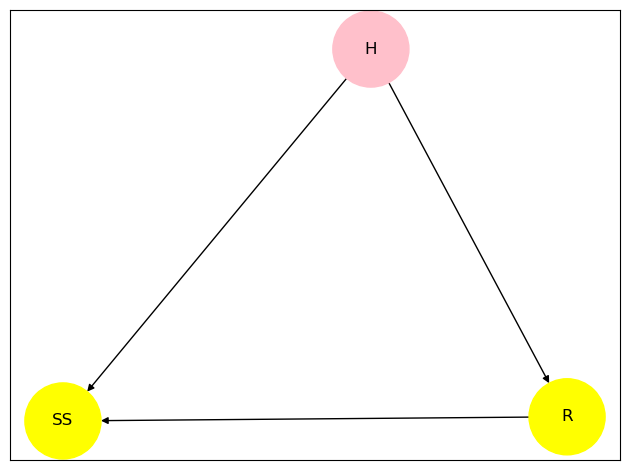

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("H", "R"), ("H","SS"), ("R","SS")])
nx.draw_networkx(graph, arrows=True, node_color= ["pink", "yellow", "yellow"], node_size=3000)
plt.tight_layout()

The DAG graph above represents the causal relationships between the reach (R), height (H), and the average frequency of significant strikes (SS). As briefly addressed in the hypothesis, the associations between the variables are made under a reasonable scientific model:

1. R = $f_{H} (R)$

The height of a fighter (H) directly influences the reach of the fighter (R) as the reach gets longer as human grows and gets taller.

2. SS = $f_SS (R, H)$

Both the the reach (R) and the height (H) directly affects the average rate of the significant strikes since having the longer reach  and being taller means that the fighter has a bigger safety zone so that one can land strikes more easily and safely.

Thus, as we see that the height (H) is a confound (H affects both R and SS  [R $\leftarrow$ H $\rightarrow$ SS]), we need to condition on the height in order to measure both the direct and total causal effects of the reach on the average frequency of the significant strikes; the height will be included in the model to measure both the direct and total causal effects of R on SS.

## Statistical Model

### Prior Predictive Simulation

Before the prior predictive simulation, the ufc_master.csv data will be explored.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as stats
import networkx as nx
from scipy.special import expit as logistic

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
df = pd.read_csv("Data/ufc-master.csv")
columns = ["BlueReachCms", "BlueHeightCms", "BlueAvgSigStrLanded"]
print(columns)
df = df[columns]
df.head()

['BlueReachCms', 'BlueHeightCms', 'BlueAvgSigStrLanded']


,BlueReachCms,BlueHeightCms,BlueAvgSigStrLanded
0,175.26,172.72,0.00
1,187.96,190.50,5.50
2,203.20,200.66,5.13
3,177.80,175.26,3.74
4,177.80,177.80,4.41


We will first examine if there exist any inappropriate data, such as NaN or negative values, and clean up the data set by dropping every rows containing the bad data.

In [14]:
# Check if there is any NaN values
print(df.isna().any().any())

# Check if there is any negative values 
print(np.where(df[columns] < 0))

# If there is any NaN values, drop them
if df.isna().any().any():
    df = df.dropna()

# Check if there is any NaN values again
print(df.isna().any().any())

False
(array([], dtype=int64), array([], dtype=int64))
False


We will now plot the standardized data points so it will visualize the min and max range of the variables.

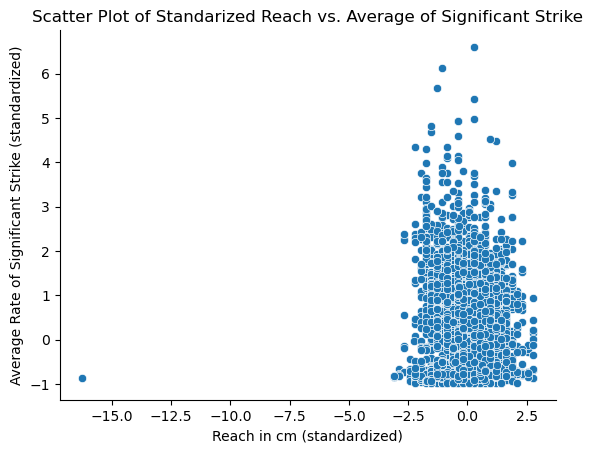

In [17]:
sns.scatterplot(x = standardize(df.BlueReachCms), y = standardize(df.BlueAvgSigStrLanded))
plt.xlabel("Reach in cm (standardized)")
plt.ylabel("Average Rate of Significant Strike (standardized)")
plt.title("Scatter Plot of Standarized Reach vs. Average of Significant Strike")
sns.despine();

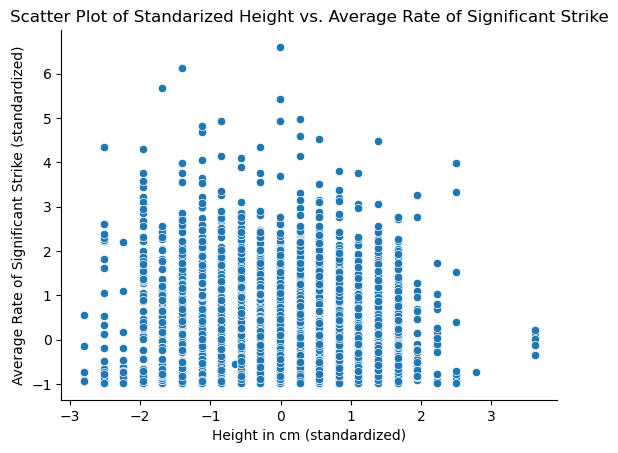

In [18]:
sns.scatterplot(x = standardize(df.BlueHeightCms), y = standardize(df.BlueAvgSigStrLanded))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Average Rate of Significant Strike (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Average Rate of Significant Strike")
sns.despine();

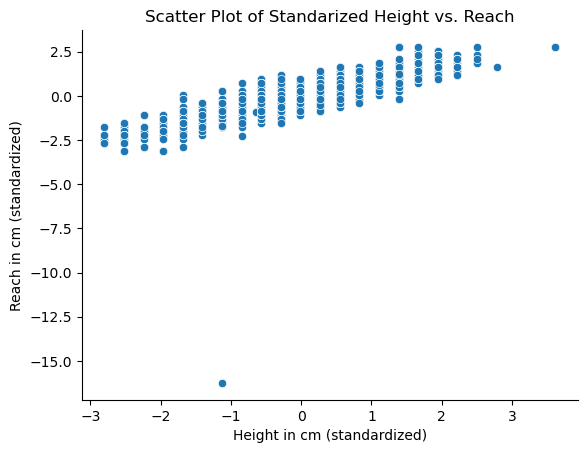

In [19]:
sns.scatterplot(x = standardize(df.BlueHeightCms), y = standardize(df.BlueReachCms))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Reach in cm (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Reach")
sns.despine();

#### Prior Predictive Simulation for Difference of Reach and Significant Strike Count

For the prior predictive simulation, it is hard to find the research data on the average difference of reach and number of the significant strikes between fighters. Due to the lack of research data on the average values of the variables, we are going to predict the reasonable prior distribution for the variables by analyzing the trend of the prior distributions of the variables compared to the average win rate of the every fighter. 

For the average win rate, we are going to assume that the average win rate of each fighter is 50% with the variance of 10%. Thus, we would be assuming that the intercept of the win rate is from 40% to 60% for every fighter.

For the difference of reach, the normal distribution will be used since the difference can be positive or negative depending on the reaches of blue and red fighters. For the range of the variable, the standardized minimum and maximum values of the reach difference among every fighter will be used. Before proceeding to find the min and max values, we will check if there is any inappropriate data in the data set.

In [8]:
# The standardized minimum reach among every fighter
every_reach = ["BlueReachCms","RedReachCms"]
print("The minimum reach among every fighter:")
print(abs(df[every_reach].min()))

The minimum reach among every fighter:
BlueReachCms      0.00
RedReachCms     147.32
dtype: float64


While we tried to find the minimum reach among every fighter, we found a row that has the blue fighter's reach = 0 cm, which is does not have an appropriate data. Thus, we will remove the specific row from the data set.

In [9]:
# Find the specific row that does not have an appropriate data
print(np.where(df["BlueReachCms"] == 0))

# Remove the specific row
df = df.drop(2335)

print(np.where(df["RedReachCms"] == 0))

(array([2335]),)
(array([], dtype=int64),)


In [10]:
# Find the minimum reach again
print("The minimum reach among every fighter:")
print(df[every_reach].min())

# Find the maximum reach
print("\nThe maximum reach among every fighter:")
print(df[every_reach].max())

The minimum reach among every fighter:
BlueReachCms    147.32
RedReachCms     147.32
dtype: float64

The maximum reach among every fighter:
BlueReachCms    213.36
RedReachCms     214.63
dtype: float64


In [11]:
# Find the minimum reach difference
print("The minimum reach difference:")
print(df["ReachDif"].min())

# Find the maximum reach difference
print("\nThe maximum reach difference:")
print(df["ReachDif"].max())

The minimum reach difference:
-187.96

The maximum reach difference:
30.48


From the min and max values above, we see that some of the values for reach difference are not correct in the data set. Thus, we will recalculate the reach difference to get a corrected reach difference and proceed to find the standardized min and max reach difference.

In [49]:
# Calculate the difference of reach
df["ReachDif_corr"] = df["RedReachCms"] - df["BlueReachCms"]
df.head()

,BlueAvgSigStrLanded,RedAvgSigStrLanded,BlueReachCms,RedReachCms,ReachDif,SigStrDif,Winner,Winner_enc,ReachDif_corr,SigStrDif_corr
0,0.00,4.41,175.26,170.18,5.08,-4.41,Red,1,-5.08,-4.41
1,5.50,4.12,187.96,195.58,-7.62,1.38,Red,1,7.62,1.38
2,5.13,5.49,203.20,205.74,-2.54,-0.36,Red,1,2.54,-0.36
3,3.74,2.30,177.80,177.80,0.00,1.44,Red,1,0.00,1.44
4,4.41,6.25,177.80,182.88,-5.08,-1.84,Blue,0,5.08,-1.84


In [13]:
# Find the minimum reach difference
print("The minimum reach difference:")
print(df["ReachDif_corr"].min())

# Find the maximum reach difference
print("\nThe maximum reach difference:")
print(df["ReachDif_corr"].max())

# Find the standardized minimum reach difference
print("\nThe standardized minimum reach difference:")
print(standardize(df["ReachDif_corr"]).min())

# Find the standardized maximum reach difference
print("\nThe standardized maximum reach difference:")
print(standardize(df["ReachDif_corr"]).max())

The minimum reach difference:
-33.01999999999998

The maximum reach difference:
30.480000000000018

The standardized minimum reach difference:
-3.955995445334259

The standardized maximum reach difference:
3.7027245504054855


Now we have the standardized min and max reach difference and will proceed to the prior predictive simulation for the reach difference. Since our output data is either 0 (blue wins) or 1 (red wins)

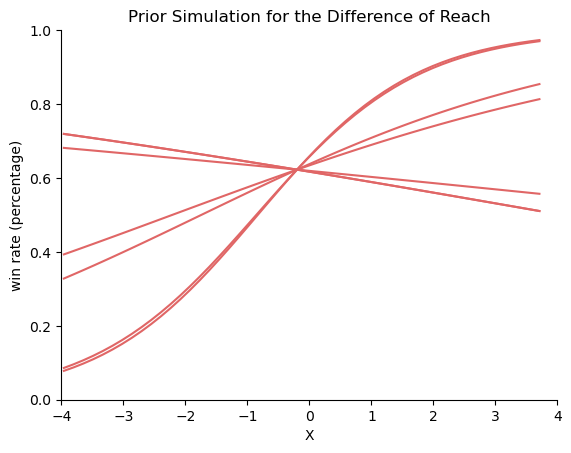

In [33]:
# First prior simulation
NUM_LINES = 7

x_seq = np.linspace(-3.96, 3.71, 50)

alpha = stats.norm.rvs(0.5, 0.1, size=NUM_LINES, random_state = 42)
beta = stats.norm.rvs(0, 0.5, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    ys = 1 / (1 + np.exp(-(alpha[i] + beta[i] * x_seq)))
    _ = plt.plot(x_seq, ys, color="#e06666")
    
_ = plt.ylabel("win rate (percentage)")
_ = plt.xlabel("X")
_ = plt.title("Prior Simulation for the Difference of Reach")
_ = plt.xlim((-4, 4))
_ = plt.ylim((0,1))
sns.despine();

While the prior distribution above seems reasonable as the win rate either increases or decreases at a reasonable rate, the distribution shows that the win rate converges to 50% when the reach difference is about -3.5, which means the win rate is about 50% when the red fighter has about 3.5cm longer reach. Thus, the appropriate distribution will be when the win rate is about 50% when the reach difference is 0. Since the distribution above shows that the win rate converges to 50%, we will keep the 

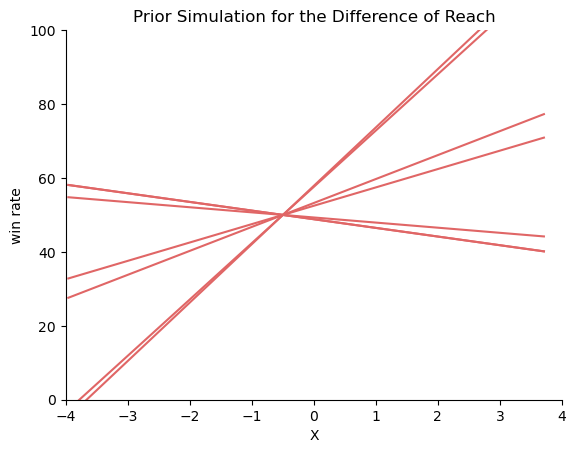

In [16]:
# First prior simulation
NUM_LINES = 7

x_seq = np.linspace(-3.96, 3.71, 50)

alpha = stats.norm.rvs(50, 5, size=NUM_LINES, random_state = 42)
beta = stats.norm.rvs(0, 10, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    ys = alpha[i] + beta[i] * x_seq
    _ = plt.plot(x_seq, ys, color="#e06666")
    
_ = plt.ylabel("win rate")
_ = plt.xlabel("X")
_ = plt.title("Prior Simulation for the Difference of Reach")
_ = plt.xlim((-4, 4))
_ = plt.ylim((0,100))
sns.despine();

For the second prior simulation, 

#### Prior Predictive Simulation for Difference of Significant Strike Count

For the difference of significant strike count, the normal distribution will be used since the difference can be positive or negative depending on the number of significant strikes of blue and red fighters. For the range of the variable, the standardized minimum and maximum values of the significant strike count difference among every fighter will be used. Before proceeding to find the min and max values, we will check if there is any data with NaN values and recalculate the difference of the significant strike count again to make sure the data is correct.

In [40]:
# Check if there is any NaN values in the interested columns
print(df[["BlueAvgSigStrLanded", "RedAvgSigStrLanded", "ReachDif_corr", "Winner_enc"]].isna().any().any())
print()

# Check how many NaN values are in the data set
print(df[["BlueAvgSigStrLanded", "RedAvgSigStrLanded", "ReachDif_corr", "Winner_enc"]].isna().sum())
print()

# Drop any data includes NaN value
df_cleaned = df[["BlueAvgSigStrLanded", "RedAvgSigStrLanded", "ReachDif_corr", "Winner_enc"]].dropna()

# Check if there is any NaN values in the interested columns again
print(df_cleaned[["BlueAvgSigStrLanded", "RedAvgSigStrLanded", "ReachDif_corr", "Winner_enc"]].isna().any().any())

df_cleaned.head()

True

BlueAvgSigStrLanded    930
RedAvgSigStrLanded     455
ReachDif_corr            0
Winner_enc               0
dtype: int64

False


,BlueAvgSigStrLanded,RedAvgSigStrLanded,ReachDif_corr,Winner_enc
0,0.00,4.41,5.08,1
1,5.50,4.12,-7.62,1
2,5.13,5.49,-2.54,1
3,3.74,2.30,0.00,1
4,4.41,6.25,-5.08,0


In [50]:
df_cleaned["SigStrDif_corr"] = df_cleaned["RedAvgSigStrLanded"] - df_cleaned["BlueAvgSigStrLanded"]
df_cleaned.head()

,BlueAvgSigStrLanded,RedAvgSigStrLanded,ReachDif_corr,Winner_enc,SigStrDif_corr
0,0.00,4.41,5.08,1,4.41
1,5.50,4.12,-7.62,1,-1.38
2,5.13,5.49,-2.54,1,0.36
3,3.74,2.30,0.00,1,-1.44
4,4.41,6.25,-5.08,0,1.84


In [42]:
# Find the minimum significant strike count difference
print("The minimum significant strike count difference:")
print(df_cleaned["SigStrDif_corr"].min())

# Find the maximum significant strike count difference
print("\nThe maximum significant strike count difference:")
print(df_cleaned["SigStrDif_corr"].max())

# Find the standardized minimum significant strike count difference
print("\nThe standardized minimum significant strike count difference:")
print(standardize(df_cleaned["SigStrDif_corr"]).min())

# Find the standardized maximum significant strike count difference
print("\nThe standardized maximum reach difference:")
print(standardize(df_cleaned["SigStrDif_corr"]).max())

The minimum significant strike count difference:
-104.66669999999999

The maximum significant strike count difference:
128.2222

The standardized minimum significant strike count difference:
-6.146192102116346

The standardized maximum reach difference:
7.569953403277341


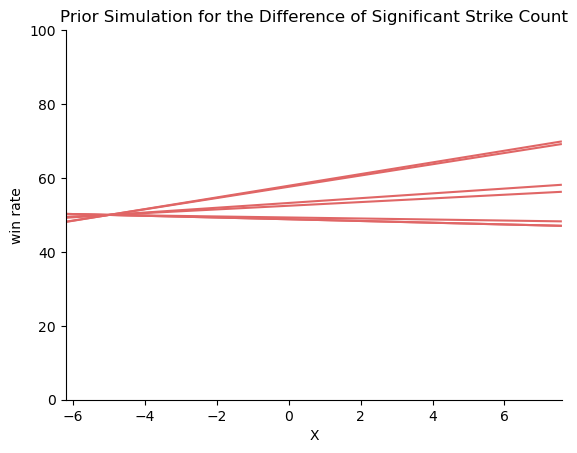

In [26]:
# First prior simulation
NUM_LINES = 7

x_seq = np.linspace(-6.15, 7.57, 50)

alpha = stats.norm.rvs(0.5, 0.1, size=NUM_LINES, random_state = 42)
beta = stats.norm.rvs(0, 1, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    ys = alpha[i] + beta[i] * x_seq
    _ = plt.plot(x_seq, ys, color="#e06666")
    
_ = plt.ylabel("win rate")
_ = plt.xlabel("X")
_ = plt.title("Prior Simulation for the Difference of Significant Strike Count")
_ = plt.xlim((-6.2, 7.6))
_ = plt.ylim((0,100))
sns.despine();

### Statistical Model to Predict the Winner

Before we start with the statistical model, we will first make sure to clean up the data so that it would exclude data that has NaN values.

In [51]:
with pm.Model() as m_SSW:
    a = pm.Normal("a", 0.5, 0.1) # Alpha winner_enc (as base)
    b_SS = pm.Normal("b_SS", 0, 0.5) # Beta for num_strikes diff
    b_R = pm.Normal("b_R", 0, 0.5) # Beta for reach diff
    p = 1 / (1 + np.exp(-(a + b_SS * df_cleaned.SigStrDif_corr + b_R * df_cleaned.ReachDif_corr)))

    W = pm.Bernoulli("W", p = p, observed=df_cleaned.Winner_enc)
    idata_SSW = pm.sample(random_seed=np.random.seed(5), return_inferencedata=True)

az.summary(idata_SSW)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b_SS, b_R]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.962,0.401,0.562,1.362,0.282,0.239,2.0,2.0,7.007070e+15
b_SS,0.384,0.036,0.348,0.420,0.025,0.022,2.0,2.0,7.007070e+15
b_R,0.743,0.173,0.571,0.916,0.122,0.103,2.0,2.0,7.007070e+15


In [52]:
temp = az.summary(idata_SSW)
logistic(temp)

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.723522,0.598928,0.636915,0.796085,0.570036,0.559467,0.880797,0.880797,1.0
b_SS,0.594837,0.508999,0.586133,0.603483,0.506250,0.505500,0.880797,0.880797,1.0
b_R,0.677652,0.543142,0.638994,0.714226,0.530462,0.525727,0.880797,0.880797,1.0
